In [17]:
import os 
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

2.3.0+cu121


In [18]:
def visualize(h, color):
    z = TSNE(n_components = 2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s = 70, c = color, cmap = 'Set2')
    plt.show()

# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [7]:
from torch_geometric.datasets import Planetoid
import torch_geometric

dataset = Planetoid(name = 'Cora', root = 'data/Platenoid', transform = torch_geometric.transforms.NormalizeFeatures())
print(f"Dataset: {dataset}")
print(f"==================")
print(f"No of graphs: {len(dataset)}")
print(f"No of classes: {dataset.num_classes}")
print(f"No of features: {dataset.num_features}")

/home/gajendra/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: Cora()
No of graphs: 1
No of classes: 7
No of features: 1433


In [8]:
data = dataset[0]

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph
print(f"No of edges: {data.num_edges}")
print(f"No of nodes: {data.num_nodes}")
print(f"Average Node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"No of training nodes: {data.train_mask.sum()}")
print(f"No of train nodes: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"does graph has Isolated Nodes: {data.has_isolated_nodes()}")
print(f"does Graph has self loops: {data.has_self_loops()}")
print(f"Graph is directed or undirected: {data.is_directed()}")


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
No of edges: 10556
No of nodes: 2708
Average Node degree: 3.90
No of training nodes: 140
No of train nodes: 0.05
does graph has Isolated Nodes: False
does Graph has self loops: False
Graph is directed or undirected: False


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [19]:
import torch


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = torch.nn.Linear(dataset.num_features, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [20]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [21]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.01, weight_decay=5e-4)

In [22]:
def train():
   model.train()

   # clear gradients
   optimizer.zero_grad()

   # perform single forward pass
   out = model.forward(data.x)

   # loss
   loss = criterion(out[data.train_mask], data.y[data.train_mask])

   # take derivatives of gradients
   loss.backward()

   # update the parameters
   optimizer.step()

   return loss

def test():
   
   model.eval()

   out = model.forward(data.x)

   # take class with highest probability 
   pred = out.argmax(dim = 1)

   # check agains the ground labels
   test_correct = pred[data.test_mask] == data.y[data.test_mask]

   # Derive ratio of correct predictions.
   test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
   
   return test_acc

After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [23]:
for epoch in range(201):
    loss = train()
    print(f"Loss: {loss:.4f}, epoch: {epoch:03d}")

Loss: 1.9615, epoch: 000
Loss: 1.9557, epoch: 001
Loss: 1.9505, epoch: 002
Loss: 1.9423, epoch: 003
Loss: 1.9327, epoch: 004
Loss: 1.9279, epoch: 005
Loss: 1.9144, epoch: 006
Loss: 1.9087, epoch: 007
Loss: 1.9023, epoch: 008
Loss: 1.8893, epoch: 009
Loss: 1.8776, epoch: 010
Loss: 1.8594, epoch: 011
Loss: 1.8457, epoch: 012
Loss: 1.8365, epoch: 013
Loss: 1.8280, epoch: 014
Loss: 1.7965, epoch: 015
Loss: 1.7984, epoch: 016
Loss: 1.7832, epoch: 017
Loss: 1.7495, epoch: 018
Loss: 1.7441, epoch: 019
Loss: 1.7188, epoch: 020
Loss: 1.7124, epoch: 021
Loss: 1.6785, epoch: 022
Loss: 1.6660, epoch: 023
Loss: 1.6119, epoch: 024
Loss: 1.6236, epoch: 025
Loss: 1.5827, epoch: 026
Loss: 1.5784, epoch: 027
Loss: 1.5524, epoch: 028
Loss: 1.5020, epoch: 029
Loss: 1.5065, epoch: 030
Loss: 1.4742, epoch: 031
Loss: 1.4581, epoch: 032
Loss: 1.4246, epoch: 033
Loss: 1.4131, epoch: 034
Loss: 1.4112, epoch: 035
Loss: 1.3923, epoch: 036
Loss: 1.3055, epoch: 037
Loss: 1.2982, epoch: 038
Loss: 1.2543, epoch: 039


In [24]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5910


As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [26]:
import torch_geometric

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = torch_geometric.nn.GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = torch.nn.functional.dropout(x, p = 0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return x


torch.nn.functional.dropout: This function applies dropout to the input tensor, randomly setting some of the elements to zero with probability p during the training phase to prevent overfitting. The remaining elements are scaled up by 1/(1-p) to maintain the expected value.

self.training: This is an attribute of torch.nn.Module which indicates whether the module is in training mode (True) or evaluation mode (False). This attribute is automatically set by calling the train() and eval() methods of the module.

In [27]:
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

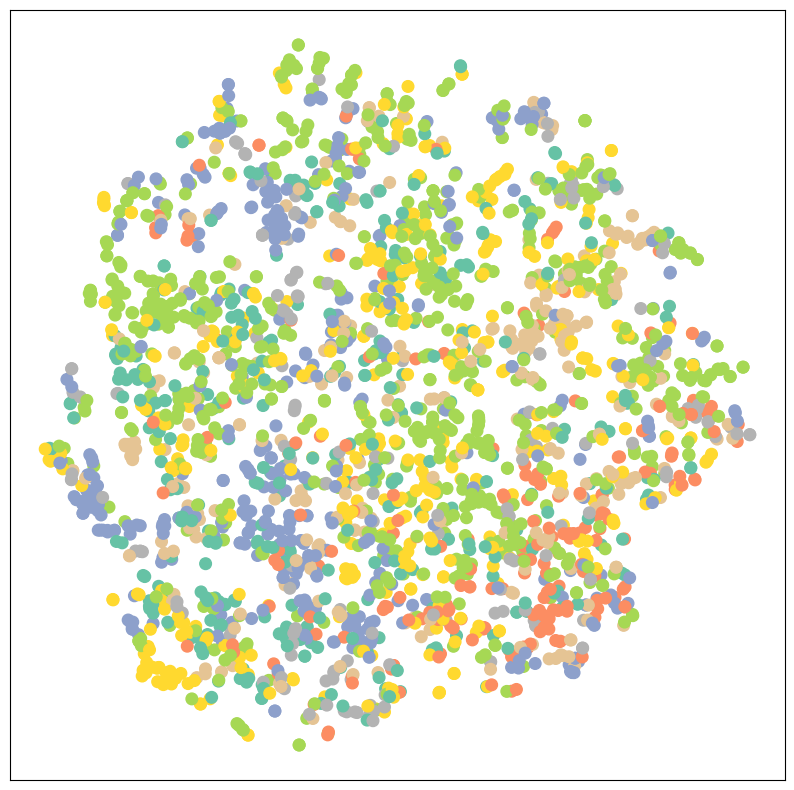

In [29]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color = data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [30]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

<IPython.core.display.Javascript object>

In [31]:
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9412
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9308
Epoch: 005, Loss: 1.9216
Epoch: 006, Loss: 1.9137
Epoch: 007, Loss: 1.9078
Epoch: 008, Loss: 1.8986
Epoch: 009, Loss: 1.8868
Epoch: 010, Loss: 1.8825
Epoch: 011, Loss: 1.8701
Epoch: 012, Loss: 1.8614
Epoch: 013, Loss: 1.8486
Epoch: 014, Loss: 1.8323
Epoch: 015, Loss: 1.8344
Epoch: 016, Loss: 1.8186
Epoch: 017, Loss: 1.8031
Epoch: 018, Loss: 1.7980
Epoch: 019, Loss: 1.7813
Epoch: 020, Loss: 1.7766
Epoch: 021, Loss: 1.7478
Epoch: 022, Loss: 1.7385
Epoch: 023, Loss: 1.7304
Epoch: 024, Loss: 1.7120
Epoch: 025, Loss: 1.7010
Epoch: 026, Loss: 1.6917
Epoch: 027, Loss: 1.6672
Epoch: 028, Loss: 1.6382
Epoch: 029, Loss: 1.6474
Epoch: 030, Loss: 1.6297
Epoch: 031, Loss: 1.6014
Epoch: 032, Loss: 1.5760
Epoch: 033, Loss: 1.5732
Epoch: 034, Loss: 1.5705
Epoch: 035, Loss: 1.5443
Epoch: 036, Loss: 1.5131
Epoch: 037, Loss: 1.4721
Epoch: 038, Loss: 1.4774
Epoch: 039, Loss: 1.4380
Epoch: 040, Loss: 1.4553


In [32]:
# Lets check test accuracy 
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

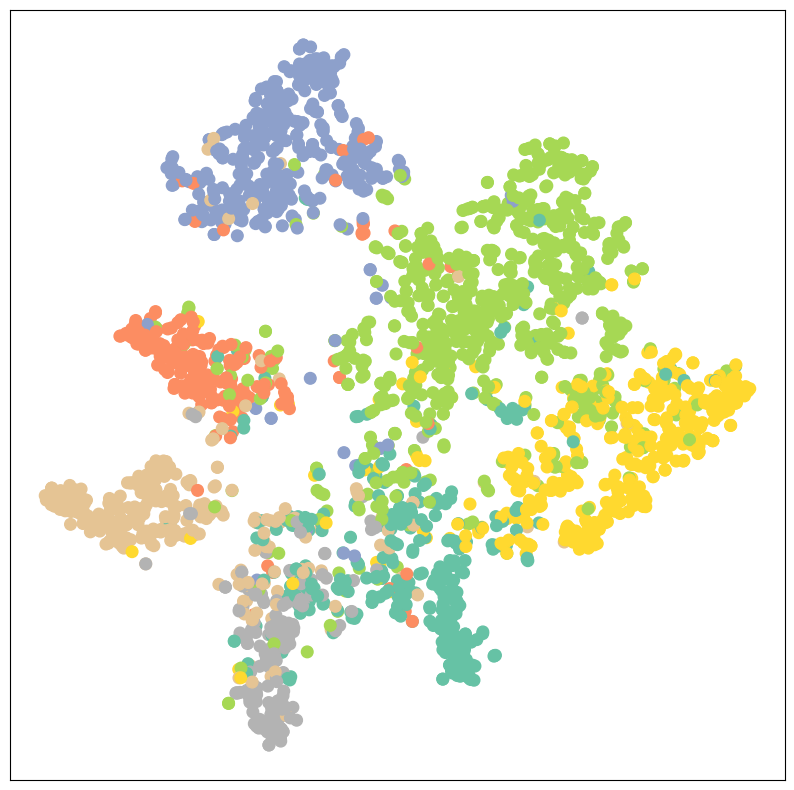

In [33]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [37]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_channels=dataset.num_features, 
                             out_channels=hidden_channels, 
                             heads=heads, 
                             dropout=0.6)  # TODO
        self.conv2 = GATConv(in_channels=hidden_channels * heads, 
                             out_channels=dataset.num_classes, 
                             heads=1, 
                             concat=False, 
                             dropout=0.6)  # TODO

    def forward(self, x, edge_index):
        x = torch.nn.functional.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)
        x = torch.nn.functional.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
Epoch: 001, Loss: 1.9429, Val: 0.1020, Test: 0.1110
Epoch: 002, Loss: 1.9383, Val: 0.0740, Test: 0.0790
Epoch: 003, Loss: 1.9299, Val: 0.0800, Test: 0.0880
Epoch: 004, Loss: 1.9304, Val: 0.0940, Test: 0.1030
Epoch: 005, Loss: 1.9177, Val: 0.1260, Test: 0.1390
Epoch: 006, Loss: 1.9124, Val: 0.1920, Test: 0.2210
Epoch: 007, Loss: 1.9073, Val: 0.3160, Test: 0.3540
Epoch: 008, Loss: 1.8998, Val: 0.4500, Test: 0.4690
Epoch: 009, Loss: 1.8949, Val: 0.4880, Test: 0.5210
Epoch: 010, Loss: 1.8843, Val: 0.5260, Test: 0.5440
Epoch: 011, Loss: 1.8819, Val: 0.5480, Test: 0.5500
Epoch: 012, Loss: 1.8664, Val: 0.5620, Test: 0.5610
Epoch: 013, Loss: 1.8625, Val: 0.5720, Test: 0.5670
Epoch: 014, Loss: 1.8506, Val: 0.5780, Test: 0.5750
Epoch: 015, Loss: 1.8493, Val: 0.6040, Test: 0.5870
Epoch: 016, Loss: 1.8390, Val: 0.6200, Test: 0.6100
Epoch: 017, Loss: 1.8163, Val: 0.6380, Test: 0.6350
Epoch: 018, Loss: 1.8316, Val: 0.6560